# Emotion Detection - JAFFE

Tester: Muhammad Aditya Bayhaqie

[Reference](https://paperswithcode.com/paper/facial-emotion-recognition-using-transfer)

## Library Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras import losses, optimizers, metrics

2025-06-12 10:52:50.078293: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749725570.272764      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749725570.332907      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Processing

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Create the main 'data' directory
if not os.path.exists('/kaggle/working/data'):
    os.makedirs('/kaggle/working/data')

# Create 'train' and 'test' subdirectories
if not os.path.exists('/kaggle/working/data/train'):
    os.makedirs('/kaggle/working/data/train')
if not os.path.exists('/kaggle/working/data/test'):
    os.makedirs('/kaggle/working/data/test')

# Define the source directory
source_dir = '/kaggle/input/jaffe-dataset/jaffe/jaffe'

# Define the emotion labels
emotions = ['NE', 'HA', 'SA', 'SU', 'AN', 'DI', 'FE']

# Create directories for each emotion within 'train' and 'test'
for emotion in emotions:
    if not os.path.exists(f'data/train/{emotion}'):
        os.makedirs(f'data/train/{emotion}')
    if not os.path.exists(f'data/test/{emotion}'):
        os.makedirs(f'data/test/{emotion}')

# List all files in the source directory
all_files = os.listdir(source_dir)

# Group files by emotion and store split files
emotion_split_files = {}
for filename in all_files:
    parts = filename.split('.')
    if len(parts) > 1:
        # The emotion seems to be the second part before the number
        # Adjust this logic if the naming convention is different
        emotion_code = parts[1][:-1] # Remove the trailing digit (e.g., 'AN1' -> 'AN')
        if emotion_code in emotions:
            if emotion_code not in emotion_split_files:
                emotion_split_files[emotion_code] = []
            emotion_split_files[emotion_code].append(filename)

# Split and copy files for each emotion
train_counts = {}
test_counts = {}
for emotion, files in emotion_split_files.items():
    if not files:
        print(f"No files found for emotion: {emotion}")
        continue

    # Split files into training and testing sets
    train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)

    train_counts[emotion] = len(train_files)
    test_counts[emotion] = len(test_files)

    # Copy training files
    for file in train_files:
        src_path = os.path.join(source_dir, file)
        dest_path = os.path.join('/kaggle/working/data/train', emotion, file)
        shutil.copy2(src_path, dest_path) # Use copy2 to preserve metadata

    # Copy testing files
    for file in test_files:
        src_path = os.path.join(source_dir, file)
        dest_path = os.path.join('/kaggle/working/data/test', emotion, file)
        shutil.copy2(src_path, dest_path)

print("Data splitting and organization complete.")
print(f"Train images per emotion: {train_counts}")
print(f"Test images per emotion: {test_counts}")

Data splitting and organization complete.
Train images per emotion: {'SA': 24, 'DI': 23, 'AN': 24, 'HA': 24, 'FE': 25, 'NE': 24, 'SU': 24}
Test images per emotion: {'SA': 7, 'DI': 6, 'AN': 6, 'HA': 7, 'FE': 7, 'NE': 6, 'SU': 6}


In [3]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np

train_dir = '/kaggle/working/data/train'
test_dir ='/kaggle/working/data/test'

img_height = 224
img_width = 224
batch_size = 32

# Function to load images as NumPy arrays
def load_images_from_directory(directory, image_size=(img_height, img_width)):
    images = []
    labels = []
    class_names = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    label_map = {name: index for index, name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, filename)
            try:
                img = keras.preprocessing.image.load_img(img_path, target_size=image_size)
                img_array = keras.utils.img_to_array(img)
                images.append(img_array)
                labels.append(label_map[class_name])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    return np.array(images), np.array(labels), class_names

# Load training and validation data
train_images, train_labels, class_names = load_images_from_directory(train_dir)
validation_images, validation_labels, _ = load_images_from_directory(test_dir)

# Convert labels to categorical
train_labels_one_hot = keras.utils.to_categorical(train_labels, num_classes=len(class_names))
validation_labels_one_hot = keras.utils.to_categorical(validation_labels, num_classes=len(class_names))

# Create TensorFlow datasets
train_generator = tf.data.Dataset.from_tensor_slices((train_images, train_labels_one_hot)).batch(batch_size).shuffle(buffer_size=100)
validation_generator = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels_one_hot)).batch(batch_size)

print("Data generators created successfully.")

Data generators created successfully.


I0000 00:00:1749725585.868832      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749725585.869542      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


(32, 224, 224, 3)


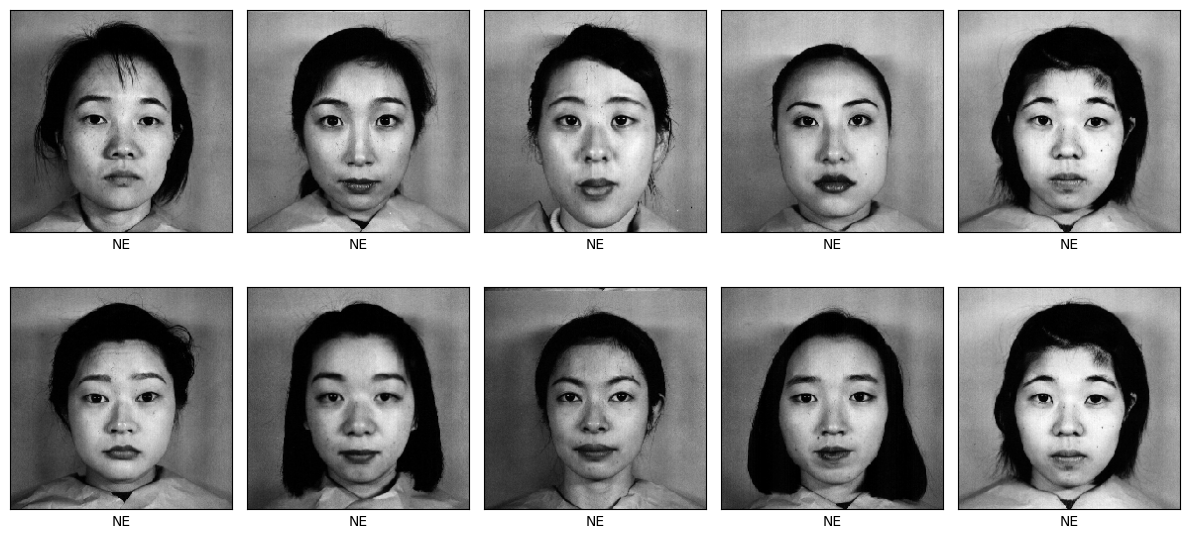

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf # Import tensorflow

# Assuming 'train_generator' is available from your previous code setup
# and 'class_names' list is available from the data loading step
# The 'classes' dictionary should reflect the actual class names
classes = {i: name for i, name in enumerate(class_names)}


# Use the 'train_generator' to get a batch
for images, cls_true_one_hot in train_generator.take(1): # Take one batch
    print(images.shape)
    # images and labels are already TensorFlow tensors

    # Convert one-hot encoded labels back to integer labels
    cls_true = tf.argmax(cls_true_one_hot, axis=1).numpy() # Convert to numpy array

    break # Get only the first batch for display

fig, axes = plt.subplots(2, 5, figsize=(12, 6)) # Added figsize for better display
axes = axes.flatten() # Flatten the 2x5 array of axes for easier iteration

# Get the number of images in the batch
num_images_in_batch = images.shape[0]

for i, ax in enumerate(axes): # Using 'ax' directly from flattened axes
    if i < num_images_in_batch: # Only display if there is an image in the batch
        # Plot image.
        # TensorFlow images are typically float [0, 255] or [0, 1]. Assuming [0, 255] from load_img
        img_display = images[i].numpy().astype(np.uint8) # Convert tensor to NumPy array (H, W, C) and to uint8

        ax.imshow(img_display)

        # Show true class.
        true_label_idx = cls_true[i] # Get the integer label

        # Use the 'classes' dictionary for mapping numerical label to string name
        xlabel = classes[true_label_idx]

        # Set the label on the x-axis.
        ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        # Hide unused subplots
        ax.axis('off')

# Ensure the plot is shown correctly with multiple plots
# in a single Notebook cell.
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

## Model Development

In [5]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      11,075,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,133,959 (42.47 MB)

 Trainable params: 11,133,959 (42.47 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [6]:
model.compile(optimizer=optimizers.Adam(2.5e-5),
              loss=losses.categorical_crossentropy,
              metrics=['accuracy']
             )

history = model.fit(
    train_generator,
    steps_per_epoch = 6,
    epochs=200,
    validation_data=validation_generator,
    validation_steps=1
)

Epoch 1/200


I0000 00:00:1749725590.920603      60 service.cc:148] XLA service 0x7c31e4008230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749725590.921536      60 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749725590.921559      60 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749725591.216511      60 cuda_dnn.cc:529] Loaded cuDNN version 90300


3/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.0243 - loss: 40.3607   

I0000 00:00:1749725595.628144      60 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 705ms/step - accuracy: 0.0500 - loss: 38.1423 - val_accuracy: 0.0000e+00 - val_loss: 37.6612
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1486 - loss: 37.6469 - val_accuracy: 0.1875 - val_loss: 15.6041
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1241 - loss: 28.2703 - val_accuracy: 0.2500 - val_loss: 17.1402
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.0865 - loss: 15.5043 - val_accuracy: 0.1875 - val_loss: 5.2273
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.0935 - loss: 7.0736 - val_accuracy: 0.0938 - val_loss: 12.1429
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1938 - loss: 8.0576 - val_accuracy: 0.1875 - val_loss: 4.8645
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1705 - loss: 3.8457 - val_accuracy: 0.2188 - val_loss: 4.5998
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2325 - loss: 3.6809 - val_accuracy: 0.1250 - val_los

## Model Evaluation

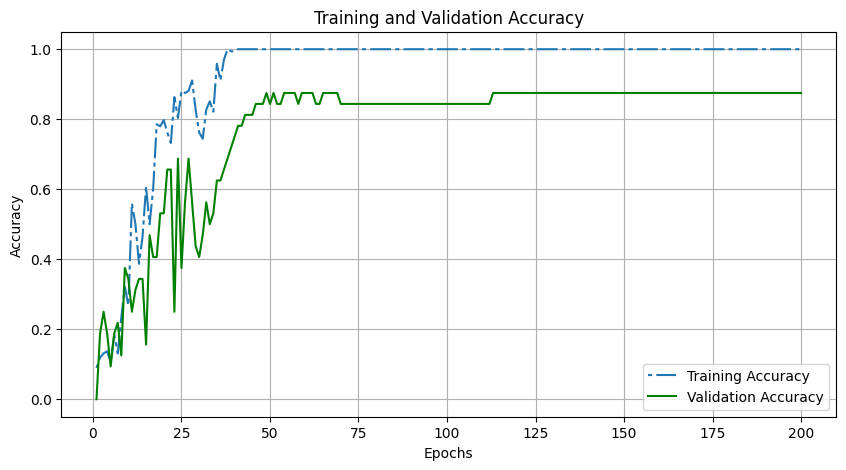

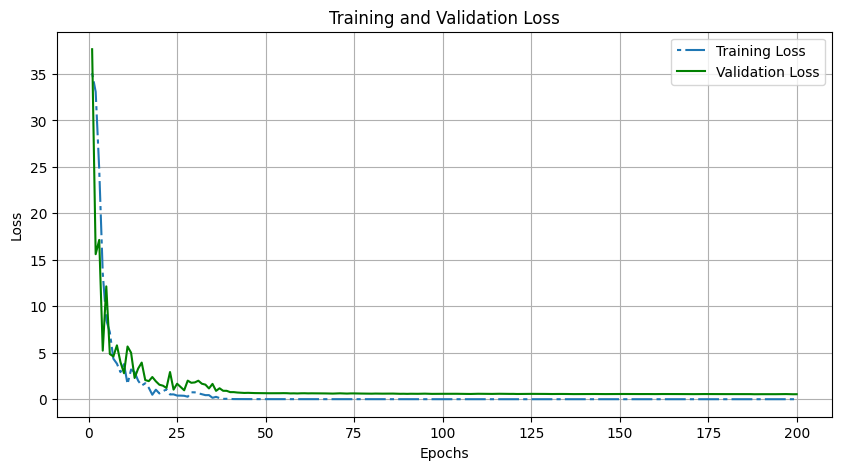

In [7]:
import matplotlib.pyplot as plt
try:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
except KeyError:
    print("Keys 'accuracy' or 'val_accuracy' not found. Trying 'acc' and 'val_acc'...")
    acc = history.history['acc']
    val_acc = history.history['val_acc']


loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5)) # Added figsize for better readability
plt.plot(epochs, acc, dashes=[2, 2, 10, 2], label='Training Accuracy') # Changed label for clarity
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy') # Changed label for clarity
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs') # Added x-axis label
plt.ylabel('Accuracy') # Added y-axis label
plt.legend()
plt.grid(True) # Added grid for better readability

plt.figure(figsize=(10, 5)) # Added figsize for better readability
plt.plot(epochs, loss, dashes=[2, 2, 10, 2], label='Training Loss') # Changed label for clarity
plt.plot(epochs, val_loss, 'g', label='Validation Loss') # Changed label for clarity
plt.title('Training and Validation Loss')
plt.xlabel('Epochs') # Added x-axis label
plt.ylabel('Loss') # Added y-axis label
plt.legend()
plt.grid(True) # Added grid for better readability

plt.show()

## Pre-Trained Model (VGG 16) Development

### Model Development

In [8]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
model = models.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,563,847 (105.15 MB)

 Trainable params: 27,563,847 (105.15 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
import tensorflow as tf
from tensorflow.keras import optimizers, losses, metrics

conv_base.trainable = False
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

model.compile(
    # FIX: Changed 'lr' to 'learning_rate' for optimizers.Adam
    optimizer=optimizers.Adam(learning_rate=5e-5),
    loss=losses.categorical_crossentropy,
    metrics=[metrics.categorical_accuracy]
)

# It's recommended to use model.fit() instead of model.fit_generator()
history = model.fit(train_generator, # Changed to model.fit()
                    steps_per_epoch=6,
                    epochs=10,
                    validation_data=validation_generator,
                    validation_steps=1)

print("\nModel compilation and training completed successfully.")


This is the number of trainable weights before freezing the conv base: 4
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - categorical_accuracy: 0.1277 - loss: 12.1462 - val_categorical_accuracy: 0.0625 - val_loss: 13.0342
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - categorical_accuracy: 0.1520 - loss: 11.8830 - val_categorical_accuracy: 0.3750 - val_loss: 7.9649
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - categorical_accuracy: 0.5049 - loss: 2.7803 - val_categorical_accuracy: 0.3750 - val_loss: 4.7246
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - categorical_accuracy: 0.6111 - loss: 1.4508 - val_categorical_accuracy: 0.6250 - val_loss: 1.9914
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - categorical_accuracy: 0.8608 - loss: 0.3967 - val_categorical_accuracy: 0.5625 - val_loss: 2.1302
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - categorical_accuracy: 0.8563 - loss: 0.3906 - val_categorical_accuracy: 0.5938 - val_loss: 2.2807
Epoch 7/10
6/6 ━━━━━━━━━━━

In [11]:
conv_base = model.layers[0]

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

### Model Training

In [12]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=5e-5),
    loss=losses.categorical_crossentropy,
    metrics=[metrics.categorical_accuracy]
)

history = model.fit(train_generator,
                              steps_per_epoch=6,
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=1)

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 794ms/step - categorical_accuracy: 0.4730 - loss: 6.4337 - val_categorical_accuracy: 0.2500 - val_loss: 12.2599
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - categorical_accuracy: 0.6519 - loss: 5.0564 - val_categorical_accuracy: 0.3750 - val_loss: 3.9201
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - categorical_accuracy: 0.6738 - loss: 1.2910 - val_categorical_accuracy: 0.4688 - val_loss: 1.9813
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - categorical_accuracy: 0.7776 - loss: 0.7192 - val_categorical_accuracy: 0.5000 - val_loss: 1.4804
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - categorical_accuracy: 0.9185 - loss: 0.1887 - val_categorical_accuracy: 0.6250 - val_loss: 1.0750
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - categorical_accuracy: 0.9665 - loss: 0.1288 - val_categorical_accuracy: 0.6875 - val_loss: 0.9974
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - categorical_accuracy: 1.0000 - loss: 0.0572 - 

### Model Evaluation

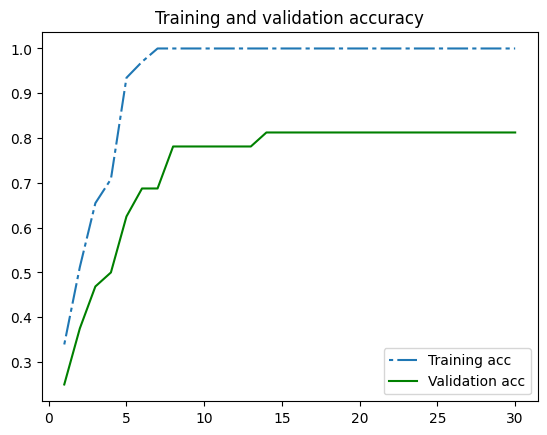

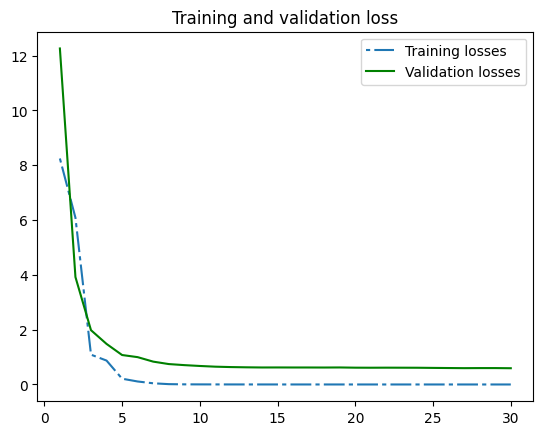

In [13]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, dashes=[2, 2, 10, 2], label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, dashes=[2, 2, 10, 2], label='Training losses')
plt.plot(epochs, val_loss, 'g', label='Validation losses')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
model.save('fully_trained_model.h5')

In [15]:
from keras.models import load_model
model = load_model('fully_trained_model.h5')

### Accuracy Prediction

In [16]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from os import listdir
import cv2
import numpy as np

# Define labels dictionary
labels = {
    0 : "AF",
    1 : "AN",
    2 : "DI",
    3 : "HA",
    4 : "NE",
    5 : "SA",
    6 : "SU"
}

# Load the trained model
# Ensure 'fully_trained_model.h5' exists in your current working directory
model = load_model('fully_trained_model.h5')
print("Model loaded successfully and ImageDataGenerator imported correctly.")

Model loaded successfully and ImageDataGenerator imported correctly.


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_dir ="/kaggle/working/data/test"


test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (224, 224),
    batch_size=24  # put batch size == total data
)

Found 45 images belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:146: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn(


In [18]:
import numpy as np
# Initialize the confusion matrix (7x7 for 7 classes)
result = [[0 for _ in range(7)] for _ in range(7)]
try:
    data, true_labels_one_hot = next(test_generator)
except StopIteration:
    print("No more batches available in test_generator. Ensure test_generator has data.")
    exit() # Exit for this example if no data is found

# Convert one-hot encoded true labels to class indices
true_labels_indices = np.argmax(true_labels_one_hot, axis=1)

# Get model predictions
predictions_one_hot = model.predict(data)
# Convert one-hot encoded predictions to class indices
predicted_labels_indices = np.argmax(predictions_one_hot, axis=1)

# Populate the confusion matrix
for i in range(len(predicted_labels_indices)):
    true_class = true_labels_indices[i]
    predicted_class = predicted_labels_indices[i]
    result[true_class][predicted_class] += 1

print("Confusion Matrix:")
# Print the confusion matrix in a readable format (optional, for verification)
for row in result:
    print(row)

# Calculate accuracy from the confusion matrix (optional)
total_samples = np.sum(result)
correct_predictions = np.trace(result) # Sum of diagonal elements
accuracy = correct_predictions / total_samples if total_samples > 0 else 0
print(f"\nCalculated Accuracy: {accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
Confusion Matrix:
[4, 0, 0, 0, 0, 0, 0]
[2, 0, 0, 0, 0, 0, 1]
[4, 0, 0, 0, 0, 0, 1]
[1, 0, 0, 0, 0, 0, 2]
[2, 0, 0, 0, 0, 1, 1]
[1, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 3]

Calculated Accuracy: 0.2917


In [19]:
result

[[4, 0, 0, 0, 0, 0, 0],
 [2, 0, 0, 0, 0, 0, 1],
 [4, 0, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 0, 2],
 [2, 0, 0, 0, 0, 1, 1],
 [1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 3]]